In [57]:
import pyaudio
from IPython.display import Audio, display, clear_output
import wave
import pickle
import numpy as np
import matplotlib as plt
import time
from scipy.io.wavfile import read
from sklearn import mixture
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn import preprocessing
import python_speech_features as mfcc


In [58]:
#Calculate and returns the delta of given feature vector matrix
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas
#convert audio to mfcc features
def extract_features(audio,rate):    
    mfcc_feat = mfcc.mfcc(audio,rate,winlen=0.025,winstep=0.01,numcep=20,nfilt=40,preemph=0.97,ceplifter=22,appendEnergy = True, nfft=1103)
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)

    #combining both mfcc features and delta
    combined = np.hstack((mfcc_feat,delta)) 
    return combined

In [56]:
#New User

In [99]:
def add_user():
    
    name = input("Enter Name:")
     # check for existing database
    if os.path.exists('./voice_database/embeddings.pickle'):
        with open('./voice_database/embeddings.pickle', 'rb') as database:
            db = pickle.load(database)   
            
            if name in db or name == 'unknown':
                print("Name Already Exists! Try Another Name...")
                return
    else:
        #if database not exists than creating new database
        db = {}
    #Voice authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3
    
    source = "./voice_database/" + name
    
   
    os.mkdir(source)
    for i in range(5):
        audio = pyaudio.PyAudio()

        if i == 0:
            j = 5
            while j>=0:
                time.sleep(1.0)
                print("Speak your name in {} seconds".format(j))
                clear_output(wait=True)

                j-=1

        elif i ==1:
            print("Speak your name again")
            time.sleep(0.5)

        elif i==2:
            print("Speak your name again")
            time.sleep(0.5)
            
        elif i==3:
            print("Speak your name again")
            time.sleep(0.5)
        elif i==4:
            print("Speak your name again")
            time.sleep(0.5)
        else:
            print("Speak your name one last time")
            time.sleep(0.5)




        # start Recording
        stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

        print("recording...")
        frames = []

        for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
            data = stream.read(CHUNK)
            frames.append(data)
        # stop Recording
        stream.stop_stream()
        stream.close()
        audio.terminate()
        # saving wav file of speaker
        waveFile = wave.open(source + '/' + str((i+1)) + '.wav', 'wb')
        waveFile.setnchannels(CHANNELS)
        waveFile.setsampwidth(audio.get_sample_size(FORMAT))
        waveFile.setframerate(RATE)
        waveFile.writeframes(b''.join(frames))
        waveFile.close()
        print("Done")
    dest =  "./gmm_models/"
    count = 1


    for path in os.listdir(source):
        path = os.path.join(source, path)

        features = np.array([])
        
        # reading audio files of speaker
        (sr, audio) = read(path)
        
        # extract 40 dimensional MFCC & delta MFCC features
        vector   = extract_features(audio,sr)

        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features, vector))
            
        # when features of 5 files of speaker are concatenated, then do model training
        if count == 5:    
            gmm = mixture.GaussianMixture(n_components = 27, max_iter = 300, covariance_type='diag',n_init = 5)
            gmm.fit(features)

            # saving the trained gaussian model
            pickle.dump(gmm, open(dest + name + '.gmm', 'wb'))
            print(name + ' added successfully') 
            
            features = np.asarray(())
            count = 0
        count = count + 1

if __name__ == '__main__':
    add_user()


recording...
Done
Speak your name again
recording...
Done
Speak your name again
recording...
Done
Speak your name again
recording...
Done
Speak your name again
recording...
Done
shraddha added successfully


In [103]:
def recognize():
    # Voice Authentication
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    CHUNK = 1024
    RECORD_SECONDS = 3
    FILENAME = "./test.wav"
    name_test=input("Enter Your name : ")
    audio = pyaudio.PyAudio()
    sr=44100
    # start Recording
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK)

    print("recording...")
    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("finished recording")


    # stop Recording
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # saving wav file 
    waveFile = wave.open(FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

    modelpath = "./gmm_models/"

    gmm_files = [os.path.join(modelpath,fname) for fname in 
                os.listdir(modelpath) if fname.endswith('.gmm')]

    models    = [pickle.load(open(fname,'rb')) for fname in gmm_files]

    speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
                in gmm_files]
  
    if len(models) == 0:
        print("No Users in the Database!")
        return
        
    #read test file
    sr,audio = read(FILENAME)
    
    # extract mfcc features
    vector = extract_features(audio,sr)
    log_likelihood = np.zeros(len(models)) 

    #checking with each model one by one
    for i in range(len(models)):
        gmm = models[i]         
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()

    pred = np.argmax(log_likelihood)
    identity = speakers[pred]
   
    # if voice not recognized than terminate the process
    if identity == name_test:
            print("Recognized as ",identity)
            return
    else:
        print( " Not Recognized")
if __name__ == '__main__':
    recognize()

Enter Your name : shraddha
recording...
finished recording
 Not Recognized


In [33]:
import librosa
x,sr=librosa.load("./voice_database/vaishali/1.wav")
mfccs=librosa.feature.mfcc(x,sr=sr)
print(mfccs.shape)

(20, 130)


In [39]:
audio_path = "./voice_database/vaishali/1.wav"
x , sr = librosa.load(audio_path)
print(type(x), type(sr))
librosa.load(audio_path, sr=44100)

<class 'numpy.ndarray'> <class 'int'>


(array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        -3.0517578e-05, -6.1035156e-05, -3.0517578e-05], dtype=float32), 44100)

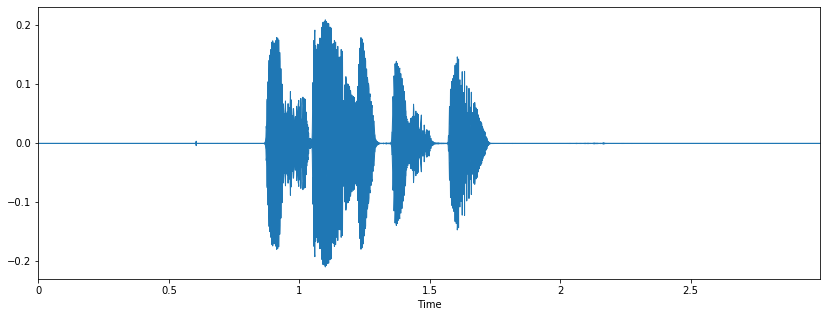

In [40]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

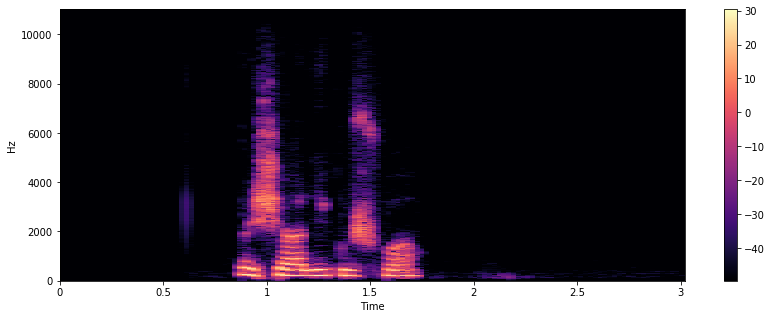

In [41]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

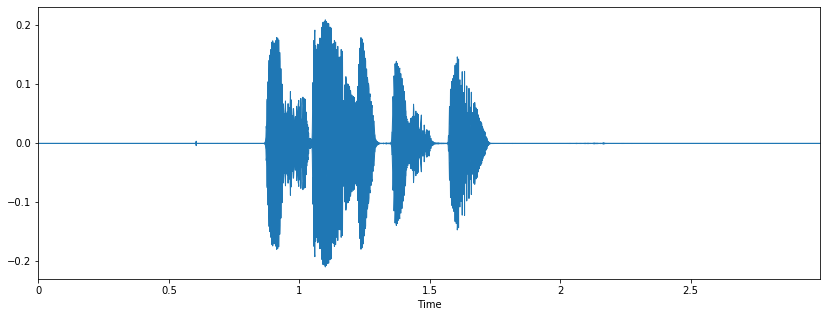

In [42]:
x, sr = librosa.load(audio_path)
#Plot the signal:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [43]:
import librosa
x,sr=librosa.load("./voice_database/vaishali2/1.wav")
mfccs=librosa.feature.mfcc(x,sr=sr)
print(mfccs.shape)

(20, 130)


In [44]:
audio_path="./voice_database/vaishali2/1.wav"
x , sr = librosa.load(audio_path)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


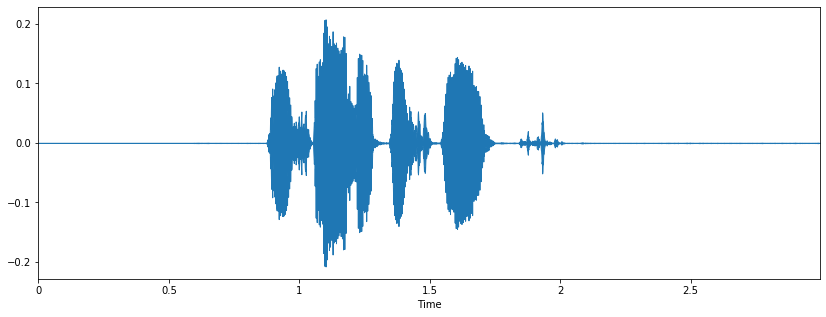

In [45]:
#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

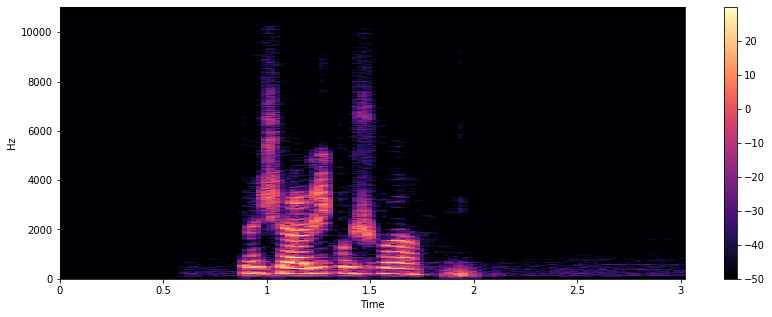

In [46]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()